# Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [27]:
58/1743

0.03327596098680436

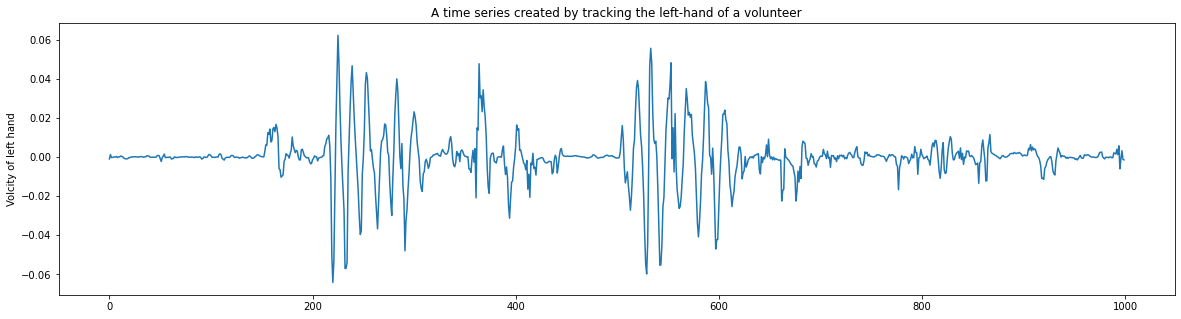

In [29]:
data_hand = np.loadtxt('dataset/a1va3.txt')[1:,1]
plt.figure(figsize=(20,5))
plt.plot(data_hand[:1000])
plt.ylabel('Volcity of left hand')
plt.title('A time series created by tracking the left-hand of a volunteer')
plt.show()

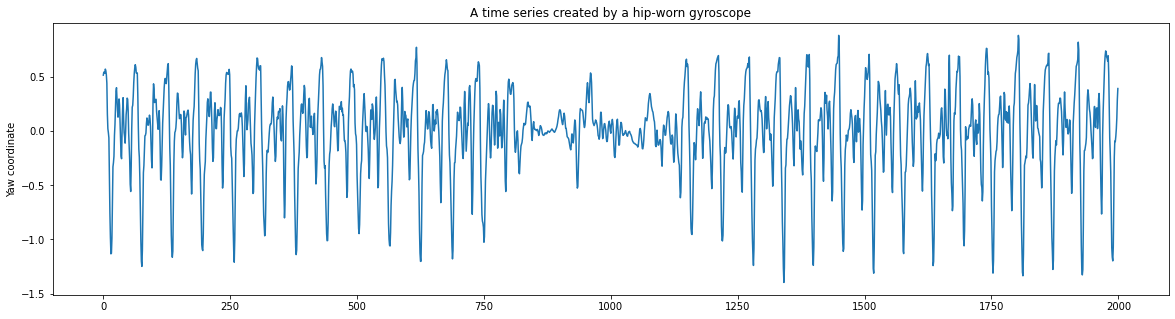

In [30]:
data_hip = np.loadtxt('dataset/gyroexp61user30_selected.txt')
plt.figure(figsize=(20,5))
plt.plot(data_hip[-2000:])
plt.ylabel('Yaw coordinate')
plt.title('A time series created by a hip-worn gyroscope')
plt.show()

# Calculate directely

In [4]:
from tslearn import metrics
import time

In [5]:
def cal_mean_var(T, L):
    means_list = []
    vars_list = []
    for i in range(len(T)-L+1):
        means_list.append(np.mean(T[i:i+L]))
        vars_list.append(np.var(T[i:i+L]))
    return means_list, vars_list

In [6]:
# Calculate DTW distance between A and B
def dtw_distance(A, B, w, A_mean, B_mean, A_var, B_var):
    # time series A and B, warping window size w
    A = (A-A_mean)/np.sqrt(A_var)
    B = (B-B_mean)/np.sqrt(B_var)
    dis = metrics.dtw(A, B, global_constraint="sakoe_chiba", sakoe_chiba_radius=w)
    return dis

In [7]:
# Using DTW to calculate matrix profile
# Here is a simple version. Furthur we can use FFT to speed up
def ComputeMatrixProfile_DTW_simple(T, L, w):
    #time series T, subsequence length L
    DTW_mp = float('inf') * np.ones(len(T)-L+1)
    DTW_index = -1 * np.ones_like(DTW_mp).astype('int')
    ml, vl = cal_mean_var(T, L)
    for i in tqdm(range(len(DTW_mp))):
        for j in range(len(DTW_mp)):
            if abs(i-j)<L: continue
            dis = dtw_distance(T[i:i+L], T[j:j+L], w, ml[i], ml[j], vl[i], vl[j])
            if dis < DTW_mp[i]:
                DTW_mp[i] = dis
                DTW_index[i] = j
    return DTW_mp, DTW_index

In [8]:
start = time.time()

DTW_mp, DTW_index = ComputeMatrixProfile_DTW_simple(data_hand[:1000], L=160, w=8)

stop = time.time()

print('\t time {:.4f}'.format(stop - start))

  0%|          | 0/841 [00:00<?, ?it/s]

	 time 68.4022


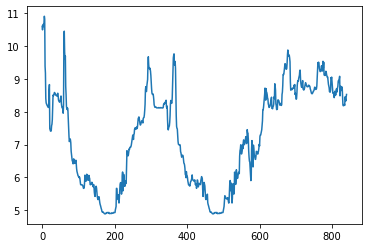

In [9]:
plt.plot(DTW_mp)

In [10]:
with open('DTW_mp.npy', 'wb') as f:
    np.save(f, DTW_mp)

In [11]:
d_i = np.argmin(DTW_mp)
d_j = DTW_index[d_i]
print(d_i, 'and ', d_j)

174 and  472


Text(0, 0.5, 'Volcity of left hand')

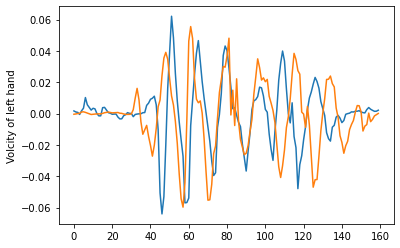

In [33]:
d_i = 174
d_j = 472
plt.plot(data_hand[d_i:d_i+160])
plt.plot(data_hand[d_j:d_j+160])
plt.ylabel('Volcity of left hand')

In [31]:
start = time.time()

DTW_mp, DTW_index = ComputeMatrixProfile_DTW_simple(data_hip[-2000:], L=256, w=4)

stop = time.time()

print('\t time {:.4f}'.format(stop - start))

  0%|          | 0/1745 [00:00<?, ?it/s]

	 time 706.8768


# Using lower bounds

In [13]:
# Calculate upper and lower envelope 
def cal_envelop(T, w):
    Up = np.zeros_like(T)
    Low = np.zeros_like(T)
    pruned = np.zeros_like(T).astype('bool')

    for i in range(len(T)):
        left = max(0, i-w)
        right = min(len(T), i+w+1)
        Up[i] = np.max(T[left:right])
        Low[i] = np.min(T[left:right])
    return Up, Low

In [14]:
# Calculate Keogh lowerbound for T and the envelopes around Q
def LB_Keo_dis(T, Up, Low, mi, mj, vi, vj):
    T = (T-mi)/np.sqrt(vi)
    Up = (Up-mj)/np.sqrt(vj)
    Low = (Low-mj)/np.sqrt(vj)
    
    diff = np.maximum(T-Up, Low-T)
    diff = np.maximum(diff, np.zeros_like(T))
    return np.sqrt(np.sum(diff**2))

In [15]:
def LB_Kim_dis(A, B, mi, mj, vi, vj):
    A = (A-mi)/np.sqrt(vi)
    B = (B-mj)/np.sqrt(vj)
    dis = (A[0]-B[0])**2+(A[-1]-B[-1])**2
    return np.sqrt(dis)

In [16]:
# Using DTW to calculate matrix profile
# Here is a simple version. Furthur we can use FFT to speed up
def ComputeMatrixProfile_DTW_prun(T, L, w):
    #time series T, subsequence length L
    DTW_mp = float('inf') * np.ones(len(T)-L+1)
    DTW_index = -1 * np.ones_like(DTW_mp).astype('int')
    ml, vl = cal_mean_var(T, L)
    
    best_so_far = 100
    Up, Low = cal_envelop(T, w)
    
    for i in tqdm(range(len(DTW_mp))):
        for j in range(i+L, len(DTW_mp)):
                
            LB_Kim = LB_Kim_dis (T[i:i+L], T[j:j+L], ml[i], ml[j], vl[i], vl[j])
            if LB_Kim > best_so_far: continue
                
            LB_Keo = LB_Keo_dis(T[i:i+L], Up[j:j+L], Low[j:j+L], ml[i], ml[j], vl[i], vl[j])
            if LB_Keo > best_so_far: continue
            
            dis = dtw_distance(T[i:i+L], T[j:j+L], w, ml[i], ml[j], vl[i], vl[j])
            if dis < DTW_mp[i]:
                DTW_mp[i] = dis
                DTW_index[i] = j
                best_so_far = min(best_so_far, dis)
    return DTW_mp, DTW_index

In [17]:
start = time.time()

DTW_mp, DTW_index = ComputeMatrixProfile_DTW_prun(data_hand[:1000], L=160, w=8)

stop = time.time()

print('\t time {:.4f}'.format(stop - start))

  0%|          | 0/841 [00:00<?, ?it/s]

	 time 19.5241


174 and  472


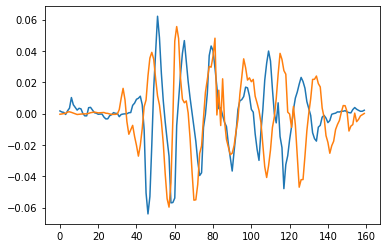

In [19]:
d_i = np.argmin(DTW_mp)
d_j = DTW_index[d_i]
print(d_i, 'and ', d_j)
plt.plot(data_hand[d_i:d_i+160])
plt.plot(data_hand[d_j:d_j+160])
plt.ylabel('Volcity of left hand')

In [23]:
start = time.time()

DTW_mp, DTW_index = ComputeMatrixProfile_DTW_prun(data_hip[-2000:], L=256, w=4)

stop = time.time()

print('\t time {:.4f}'.format(stop - start))

  0%|          | 0/1745 [00:00<?, ?it/s]

	 time 56.3210


Text(0, 0.5, 'Yaw coordinate')

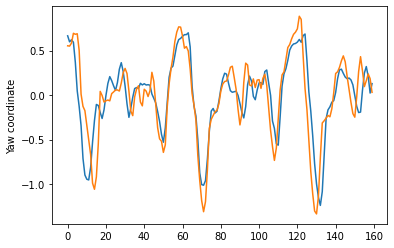

In [34]:
d_i = np.argmin(DTW_mp)
d_j = DTW_index[d_i]
d_i-=2000
d_j-=2000
plt.plot(data_hip[d_i:d_i+160])
plt.plot(data_hip[d_j:d_j+160])
plt.ylabel('Yaw coordinate')